# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Andrea Piredda, 61801
## Student 2: Linus Lüdecke, 58411


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [2]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



mkdir: checkpoint: File exists


## Setup

The following cell will import the used packages.

In [3]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
WITH_SPARK = True

if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

ls: /content/drive/MyDrive/sbe2324ada: No such file or directory


In [5]:
DATASET_DIR = "DATASET_DIR"

# FOR running in Colab
#DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

#Small dataset
#TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
TXDATA_FILE = "290001-300000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"
TXDATA_FILE_LABELS = "labels-290001-300000.csv.gz"



### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


# Dumps basic infomation using Spark Pandas API
WITH_SPARK = True
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [14]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)
inputDF.to_csv("inputDF.csv", index=False)
outputDF.to_csv("outputDF.csv", index=False)


TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


23/12/02 15:37:09 INFO InMemoryFileIndex: It took 123 ms to list leaf files for 1 paths.


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes


           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")



outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


### Results (Pandas)

The time to process the small dataset was : 0.72 seconds.

The time to process the large dataset was : 271.43 seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


### Results (Spark)

The time to process the small dataset was : 4.08 seconds.

The time to process the large dataset was : 128.83 seconds.



### Discussion:

- For the small dataset Pandas is faster, as it doesn't have distribution overhead. It completes the computation in 0.72 seconds, while spark requires 4.08 seconds.
- For the large dataset Pandas runs a lot slower because it has load all data into memory, while Spark can distribute processes across a cluster of machines. Spark requires 128.83 seconds while Pandas requires 271.43 seconds.

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
#spark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Top 10 Transactions").getOrCreate()
transactionSDF.createOrReplaceTempView("transaction_table")
top10 = spark.sql("""
SELECT *
FROM transaction_table
ORDER BY Sum DESC
LIMIT 10
""")
top10.show()

+--------+------+---------+-------------------+
|    txid|height|      sum|               time|
+--------+------+---------+-------------------+
|294337:0|294337|  85993.0|2014-04-05 10:41:41|
|294382:0|294382|  82993.0|2014-04-05 17:39:28|
|296278:0|296278|  78693.0|2014-04-17 07:32:40|
|297111:0|297111|  70693.0|2014-04-22 07:46:00|
|297192:3|297192|  68693.0|2014-04-22 20:11:23|
|298176:0|298176|  64693.0|2014-04-28 18:34:03|
|298824:0|298824|  63193.0|2014-05-02 19:49:26|
|291839:0|291839|  28879.0|2014-03-22 11:59:03|
|293885:0|293885|  23879.0|2014-04-03 02:41:59|
|296169:0|296169|20027.229|2014-04-16 16:38:19|
+--------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of USD currency.

In [ ]:
from pyspark.sql.functions import to_date
spark = SparkSession.builder.appName("Data Processing").getOrCreate()
priceDF['Date'] = pd.to_datetime(priceDF['Date']).dt.date
priceDF_spark = spark.createDataFrame(priceDF)

dataset.createOrReplaceTempView("dataset_view")
priceDF_spark.createOrReplaceTempView("priceDF_view")

top10_USD = spark.sql("""
    SELECT *, (dataset_view.Sum * priceDF_view.Price) AS USD
    FROM dataset_view
    LEFT JOIN priceDF_view ON date(dataset_view.Time) = priceDF_view.Date
    ORDER BY USD DESC
    LIMIT 10
""")

top10_USD.show()



/Users/linusludecke/anaconda3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/12/02 15:53:01 INFO FileSourceStrategy: Pushed Filters: IsNotNull(Time),GreaterThanOrEqual(Time,2014-03-01 00:00:00.0)
23/12/02 15:53:01 INFO FileSourceStrategy: Post-Scan Filters: isnotnull(time#43),(time#43 >= 2014-03-01 00:00:00)
23/12/02 15:53:01 INFO FileSourceStrategy: Output Data Schema: struct<TxId: string, Height: int, Input: string, Output: string, Sum: float ... 1 more field>
23/12/02 15:53:01 INFO CodeGenerator: Code generated in 54.699834 ms
23/12/02 15:53:01 INFO MemoryStore: Block broadcast_35 stored as values in memory (estimated size 339.5 KiB, free 363.3 MiB)
23/12/02 15:53:01 INFO MemoryStore: Block broadcast_35_piece0 stored as bytes in memory (estimated size 32.8 KiB, free 363.3 MiB)
23/12/02 15:53:01 INFO BlockManagerInfo: Adde

+--------+------+--------------------+--------------------+---------+-------------------+----------+-----+--------------------+
|    TxId|Height|               Input|              Output|      Sum|               Time|      Date|Price|                 USD|
+--------+------+--------------------+--------------------+---------+-------------------+----------+-----+--------------------+
|296278:0|296278|['1FFiXAwoeLDvzPm...|[[['1JgXeXaAvBgdK...|  78693.0|2014-04-17 07:32:40|2014-04-17|502.0|         3.9503886E7|
|294337:0|294337|['17ewBhK712mY2E4...|[[['153axhS1Xs3ev...|  85993.0|2014-04-05 10:41:41|2014-04-05|456.6|3.9264403800000004E7|
|294382:0|294382|['153axhS1Xs3evJ5...|[[['1Drt3c8pSdrky...|  82993.0|2014-04-05 17:39:28|2014-04-05|456.6|3.7894603800000004E7|
|297111:0|297111|['1JgXeXaAvBgdKN9...|[[['1Drt3c8pSdrky...|  70693.0|2014-04-22 07:46:00|2014-04-22|487.9|3.4491114699999996E7|
|297192:3|297192|['1FP7sqERBQLqDSE...|[[['14LBeJ5bZQK1o...|  68693.0|2014-04-22 20:11:23|2014-04-22|487.

23/12/02 15:54:01 INFO CodeGenerator: Code generated in 51.421125 ms


### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


23/12/02 15:47:55 INFO FileSourceStrategy: Pushed Filters: IsNotNull(Time),GreaterThanOrEqual(Time,2014-03-01 00:00:00.0)
23/12/02 15:47:55 INFO FileSourceStrategy: Post-Scan Filters: isnotnull(time#43),(time#43 >= 2014-03-01 00:00:00)
23/12/02 15:47:55 INFO FileSourceStrategy: Output Data Schema: struct<TxId: string, Time: timestamp>
23/12/02 15:47:55 INFO MemoryStore: Block broadcast_25 stored as values in memory (estimated size 339.5 KiB, free 364.2 MiB)
23/12/02 15:47:55 INFO MemoryStore: Block broadcast_25_piece0 stored as bytes in memory (estimated size 32.8 KiB, free 364.2 MiB)
23/12/02 15:47:55 INFO BlockManagerInfo: Added broadcast_25_piece0 in memory on linuss-mbp.home:54587 (size: 32.8 KiB, free: 366.0 MiB)
23/12/02 15:47:55 INFO SparkContext: Created broadcast 25 from collect at /var/folders/lm/p8fp0yss5h93z492jjwtmzv40000gn/T/ipykernel_73652/1276764138.py:14
23/12/02 15:47:55 INFO FileSourceScanExec: Planning scan with bin packing, max size: 69029219 bytes, open cost is co

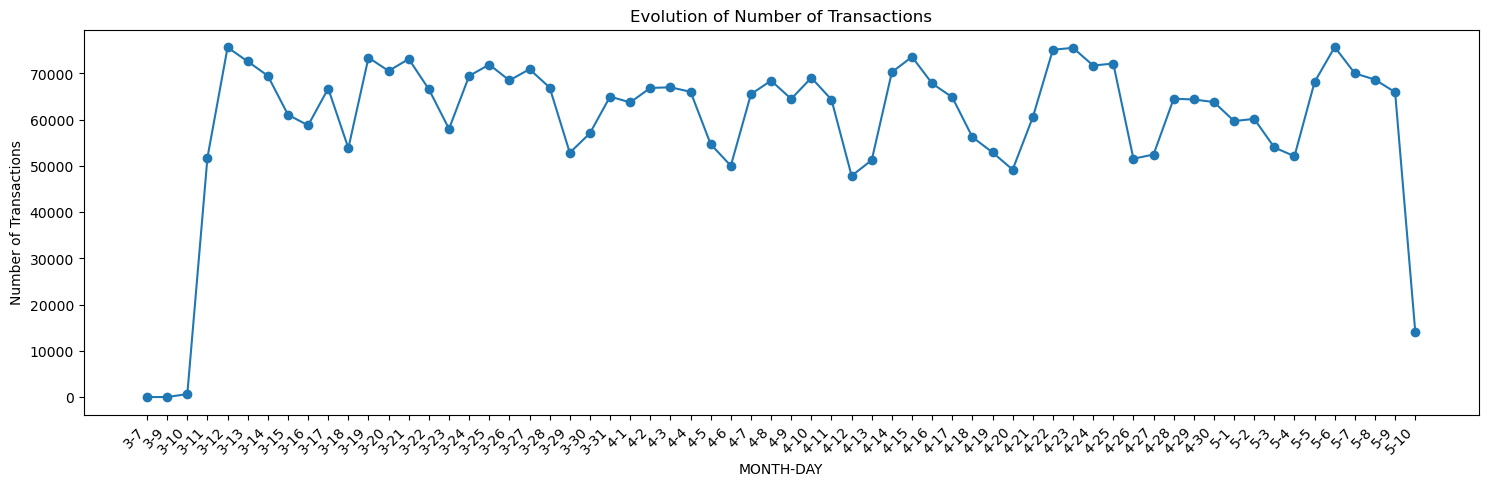

In [ ]:
dataset= dataset.filter(col("time") >= to_timestamp(lit("2014-03-01 00:00:00")))


dataset.createOrReplaceTempView("temp_view")

transactions_per_month_year = spark.sql("""
    SELECT MONTH(Time) AS MONTH, DAY(Time) AS DAY, COUNT(TxId) AS `Transaction Count`
    FROM temp_view
    GROUP BY MONTH(Time), DAY(Time)
    ORDER BY MONTH, DAY
""")

# Convert the result to a Pandas DataFrame for local plotting
result = transactions_per_month_year.collect()

# Extract the data for plotting
months_days = [f"{row['MONTH']}-{row['DAY']}" for row in result]
counts = [row['Transaction Count'] for row in result]

plt.figure(figsize=(18, 5))
ax = plt.gca()  # Get the current Axes instance

# Plotting the line plot
ax.plot(months_days, counts, marker='o', linestyle='-')
ax.set_xticklabels(months_days, rotation=45, ha='right')  # Setting x-axis tick labels

# Adding labels and title
plt.xlabel('MONTH-DAY')
plt.ylabel('Number of Transactions')
plt.ticklabel_format(axis='y', style='plain')
plt.title('Evolution of Number of Transactions')

# Show the plot
plt.show()


### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


23/12/02 16:03:52 INFO FileSourceStrategy: Pushed Filters: IsNotNull(Time),GreaterThanOrEqual(Time,2014-03-01 00:00:00.0)
23/12/02 16:03:52 INFO FileSourceStrategy: Post-Scan Filters: isnotnull(time#43),(time#43 >= 2014-03-01 00:00:00)
23/12/02 16:03:52 INFO FileSourceStrategy: Output Data Schema: struct<Sum: float, Time: timestamp>
23/12/02 16:03:52 INFO MemoryStore: Block broadcast_79 stored as values in memory (estimated size 339.5 KiB, free 355.0 MiB)
23/12/02 16:03:52 INFO MemoryStore: Block broadcast_79_piece0 stored as bytes in memory (estimated size 32.8 KiB, free 355.0 MiB)
23/12/02 16:03:52 INFO BlockManagerInfo: Added broadcast_79_piece0 in memory on linuss-mbp.home:54587 (size: 32.8 KiB, free: 365.6 MiB)
23/12/02 16:03:52 INFO SparkContext: Created broadcast 79 from collect at /var/folders/lm/p8fp0yss5h93z492jjwtmzv40000gn/T/ipykernel_73652/563542239.py:11
23/12/02 16:03:52 INFO FileSourceScanExec: Planning scan with bin packing, max size: 69029219 bytes, open cost is consi

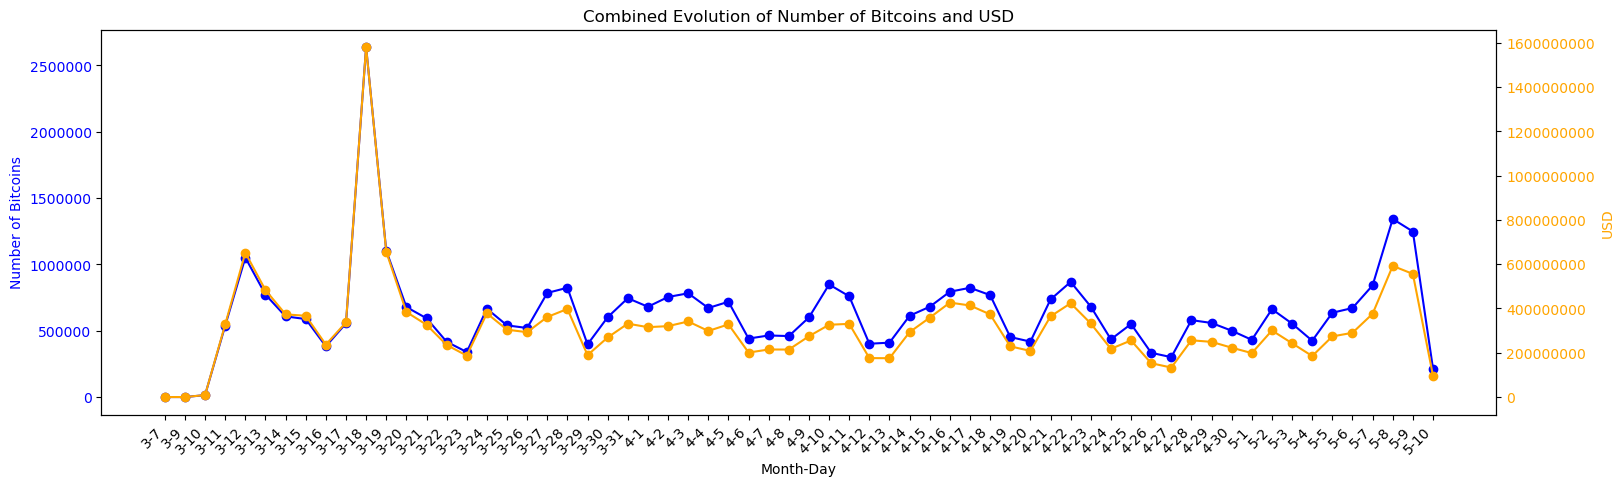

In [ ]:
dataset.createOrReplaceTempView("bitcoin_view")


bitcoin_per_month_day = spark.sql("""
    SELECT MONTH(Time) AS Month, DAY(Time) AS Day, SUM(Sum) AS Bitcoin
    FROM bitcoin_view
    GROUP BY MONTH(Time), DAY(Time)
    ORDER BY Month, Day
""")

result_bitcoin = bitcoin_per_month_day.collect()

# Extract the data for plotting
months_days = [f"{row['Month']}-{row['Day']}" for row in result_bitcoin]
bitcoins = [row['Bitcoin'] for row in result_bitcoin]

dataset.createOrReplaceTempView("USD_view")
priceDF_spark.createOrReplaceTempView("priceDF_view")

USD_per_month_day = spark.sql("""
    SELECT MONTH(Time) AS Month, DAY(Time) AS Day, SUM(USD_view.Sum * priceDF_view.Price) AS USD
    FROM USD_view
    LEFT JOIN priceDF_view ON date(USD_view.Time) = priceDF_view.Date

    GROUP BY MONTH(Time), DAY(Time)
    ORDER BY Month, Day
""")

result_USD = USD_per_month_day.collect()

# Extract the data for plotting
months_days = [f"{row['Day']}-{row['Month']}" for row in result_USD]
USD = [row['USD'] for row in result_USD]

fig, ax1 = plt.subplots(figsize=(18, 5))
ax1.plot(months_days, bitcoins, marker='o', linestyle='-', color='blue')

# Plotting the USD data on the second y-axis
ax2 = ax1.twinx()
ax2.plot(months_days, USD, marker='o', linestyle='-', color='orange')

# Adding labels and title for the first y-axis
ax1.set_xlabel('Month-Day')
ax1.set_ylabel('Number of Bitcoins', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.ticklabel_format(axis='y', style='plain')

# Adding labels and title for the second y-axis
ax2.set_ylabel('USD', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.ticklabel_format(axis='y', style='plain')



# Set x-axis labels to 45-degree rotation
ax1.set_xticklabels(months_days, rotation=45, ha='right')

# Title for the combined plot
plt.title('Combined Evolution of Number of Bitcoins and USD')

# Show the plot
plt.show()



The first output presents the top 10 largest Bitcoin transactions by nominal value. This primarily highlights that some transactions involve large volumes of Bitcoin, but doesn't offer much deeper insight.

In the second output, we merged the 'dataset' with 'priceDF' to obtain the daily Bitcoin-to-USD conversion rates. From this merged data, we observed a day-by-day changes in the value of Bitcoin in USD. It is interesting to note that the top 10 transactions in USD differ from the top 10 in Bitcoin due to movement in the Bitcoin Value.

Regarding the volume of transactions over time, we chose to exclude data before March 7, considering it less relevant for our analysis and posed as outliers. Post this date, the daily transaction volume mostly ranged between 50,000 and 70,000. However, on May 10, we noticed a significant drop, with the volume falling to just below 20,000 transactions, which might be due to the fact that further transactions on that day are included in a different datatset. This was determined using a Spark SQL code that counts each Transaction ID.

Finally, the last output displays the total value of Bitcoins and dollars transferred. Our query involved summing all transaction values and plotting them as a line chart. This was compared against the total USD value transferred, which we calculated by joining the 'dataset' and 'priceDF' again and summing the product of the BTC-to-USD exchange rate with the sum of Bitcoins transferred.

## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [ ]:
#Balance
def calculate_balances(dataset):
    balances = {}

    for index, row in dataset.iterrows():
        inputs = row['Input']
        outputs = row['Output']

        for input_address in inputs:
            if input_address not in balances:
                balances[input_address] = 0
            balances[input_address] = 0

        for output_address, value in outputs:
            if output_address not in balances:
                balances[output_address] = 0
            balances[output_address] += value

    return balances

account_balances = calculate_balances(df)

account_balance_df = pd.DataFrame(list(account_balances.items()), columns=['Address', 'Balance'])
account_balance_df.head()




,Address,Balance
0,17WqA7z67HvhNoSaZ4X5YfuhwW2hjSRViQ,1103.5410
1,16SUYiQ1AAsYnKnML71F7rFC35iRsEnUog,0.0000
2,1LKyrVaVbnNDtH3ZpsFXjA1GyRmSPBxow6,93.8999
3,1QA3WPedD6ecZdvXtDXnVRbbZBPgrHCJms,0.0000
4,1GJaFGAkEGYEk8L6hjpQBkWxtFwEsgC8YX,0.0000


In [ ]:
#Transaction count
inputDF_renamed= inputDF[['TxId', 'Time', 'Input']].rename(columns={'Input': 'Address'})
outputDF_renamed= outputDF[['TxId', 'Time', 'Output','Value']].rename(columns={'Output': 'Address'})

merged_df = pd.merge(outputDF_renamed, inputDF_renamed, on=['TxId', 'Address'], how='left', indicator=True)
filtered_outputDF_renamed = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
concat = pd.concat([inputDF_renamed, filtered_outputDF_renamed], ignore_index=True)

transaction_count = concat.groupby("Address").size().reset_index(name="Transaction_Count").sort_values(by="Transaction_Count",ascending=False)
transaction_count.head()

,Address,Transaction_Count
5644377,1bonesF1NYidcd5veLqy1RZgF4mpYJWXZ,73514
5648145,1changemCPo732F6oYUyhbyGtFcNVjprq,62338
5250521,1NxaBCFQwejSZbQfWcYNwgqML5wWoE3rK4,51196
4737448,1LuckyR1fFHEsXYyx5QK4UFzv3PEAepPMK,44542
4737444,1LuckyG4tMMZf64j6ea7JhCz7sDpk6vdcS,35021


In [ ]:
#Average and Max Output Transaction Value
inputDF_renamed= inputDF[['TxId', 'Time', 'Input']].rename(columns={'Input': 'Address'})
outputDF_renamed= outputDF[['TxId', 'Time', 'Output','Value']].rename(columns={'Output': 'Address'})

filtered_outputDF_renamed = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
filtered_outputDF_renamed["Value"]=filtered_outputDF_renamed["Value"].astype(float)

max_output_value = filtered_outputDF_renamed.groupby("Address").max(numeric_only=True)["Value"].reset_index()

average_output_value = filtered_outputDF_renamed.groupby("Address").mean(numeric_only=True)["Value"].reset_index()
average_output_value = average_output_value.rename(columns={'Value': 'Average_Output'})
average_output_value = average_output_value.merge(max_output_value,on="Address",how="inner").rename(columns={'Value': 'Max_Output'})
average_output_value.head()

,Address,Average_Output,Max_Output
0,1111111111111111111114oLvT2,0.000100,0.000100
1,1111111AgxDnb8UWCwZnJGUNrX6cAzaL,0.019800,0.019800
2,1111127SpvabYpoeDoiz5L7QPkfiSh2Q,0.003316,0.006524
3,11111414zPMtpC1Uz4buygejXLgcBY5VY,0.154389,0.154389
4,11113JJWv5JC4Ld3pfe5s8cAAjGz1PLTw,0.005555,0.030400


23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_90_piece0 on linuss-mbp.home:54587 in memory (size: 28.2 KiB, free: 365.5 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_92_piece0 on linuss-mbp.home:54587 in memory (size: 24.9 KiB, free: 365.5 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_91_piece0 on linuss-mbp.home:54587 in memory (size: 28.7 KiB, free: 365.5 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_15_piece0 on linuss-mbp.home:54587 in memory (size: 32.8 KiB, free: 365.5 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_10_piece0 on linuss-mbp.home:54587 in memory (size: 32.8 KiB, free: 365.6 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_51_piece0 on linuss-mbp.home:54587 in memory (size: 32.8 KiB, free: 365.6 MiB)
23/12/02 16:15:05 INFO BlockManagerInfo: Removed broadcast_89_piece0 on linuss-mbp.home:54587 in memory (size: 26.4 KiB, free: 365.6 MiB)
23/12/02 16:15:05 INFO BlockManage

#### Discussion


The first statistic we calculated is the balance of each account. We began by initializing an empty dictionary to store the balances, ensuring each address would be uniquely represented. Within a loop structure, we processed inputs and outputs from each transaction, adding new addresses to the dictionary as needed. The function systematically updates each address's balance, setting balance to zero for inputs (as Bitcoin requires full use of wallet's balance for each input transaction) and crediting for outputs. This operation results in a comprehensive ledger of address balances. It is important to note that this way of calculating the balance assumes that the balance was 0 for all addresses present in the dataset, this assumption does not hold in reality, therefore analyses involving the balance are to be interpreted with caution.

Moving to our second statistic, the transaction count per account, we prepared the data by standardizing column names across two datasets, outputDF and inputDF, to a common identifier 'address' and by removing transactions that had the same address for input and output, as this usually represents a reimbursement and should not be considered a transaction. This allowed for a seamless merge of the datasets, enabling us to aggregate and tally the number of transactions associated with each address.

Finally, our third statistic aimed at calculating the average and the maximum transaction value of each address. Following the same logic as the previous statistic, we merged the two datasets by creating a common column, removed transactions where input and output was the same, grouped by address and first calculated the maximum transaction, and afterwards we calculated the mean to find the average transaction per account.

Again, it is important to reiterate that all statistcis calculated are subject to sampling errors, as we only use a subset of the full bitcoin ledger. The average transaction value, balance and transaction per account might differ significantly if we were to include all bitcoin transactions. For the purpose of simplicty, it is assumed that our dataset includes all bitcoin transactions over time.


## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, average amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


In [ ]:
#average_partners_per_day
concat = pd.concat([inputDF_renamed, filtered_outputDF_renamed], ignore_index=True)
concat['Time'] = pd.to_datetime(concat['Time'])
concat['Date'] = concat['Time'].dt.date
partners_per_day = concat.groupby(['Date', 'Address']).size().reset_index(name='Transaction_Count')
average_partners_per_day = partners_per_day.groupby('Address')['Transaction_Count'].mean().reset_index(name='Average_Partners_Per_Day').sort_values(by="Average_Partners_Per_Day",ascending=False)
average_partners_per_day

,Address,Average_Partners_Per_Day
2237720,1BitZuoGD8QUvRjVwbD1B5u1qg8aYj9ABE,1342.428571
5182151,1changemCPo732F6oYUyhbyGtFcNVjprq,720.915254
5178683,1bonesF1NYidcd5veLqy1RZgF4mpYJWXZ,519.278689
5182150,1changeLdDQGQqFKY2VxyJHiEBzoxL3hN,485.000000
3250551,1G8VTQWhA2Cq9pBRTruEBfU3EHURSZspgf,482.571429
...,...,...
1811115,19s1ndJwpeHPqRT9cyYHfsCp4FJ7znL81N,1.000000
1811114,19s1mWq4QX6vW1U74xxhgYnxTi3KbNbMKS,1.000000
1811113,19s1kckqpaNt9YfwdJManbJ2jH9G1NxyV,1.000000
1811112,19s1jmZXjsnpYvz7SgVj59GTA5amfgiiMx,1.000000


In [ ]:
#Output Proportion + Counts
input_count=inputDF_renamed.groupby("Address").count()["TxId"].reset_index().sort_values(by="TxId",ascending=False)
output_count = filtered_outputDF_renamed.groupby("Address").count()["TxId"].reset_index().sort_values(by="TxId",ascending=False)
counts_merged= input_count.merge(output_count,on="Address",how="outer").fillna(0)
counts_merged["Output_Proportion"]=(counts_merged["TxId_y"]/(counts_merged["TxId_y"] + counts_merged["TxId_x"]))
output_proportion = counts_merged.rename(columns={"TxId_x": "Input_Count", "TxId_y": "Output_Count"})
output_proportion

,Address,Input_Count,Output_Count,Output_Proportion
0,1changemCPo732F6oYUyhbyGtFcNVjprq,42534.0,19804.0,0.317687
1,1bonesF1NYidcd5veLqy1RZgF4mpYJWXZ,31676.0,41838.0,0.569116
2,1LuckyR1fFHEsXYyx5QK4UFzv3PEAepPMK,26633.0,17909.0,0.402070
3,1LuckyG4tMMZf64j6ea7JhCz7sDpk6vdcS,19071.0,15950.0,0.455441
4,1NxaBCFQwejSZbQfWcYNwgqML5wWoE3rK4,17297.0,33899.0,0.662142
...,...,...,...,...
5748609,1A828PwjnRwdwWDBNYhr4GtZgcZG9tQidw,0.0,1.0,1.000000
5748610,1A822oawdob6Tmvv8ZtAEcKRewsHWzWxyj,0.0,1.0,1.000000
5748611,1A81zK8kCcuKS2Jo79WFktjhz7DMiGWDpj,0.0,1.0,1.000000
5748612,1A81xeDocAsWmX3VDXxKFKksRzQiuVgrQN,0.0,1.0,1.000000


In [ ]:
#Transactions per Day
inputDF_renamed= inputDF[['TxId', 'Time', 'Input']].rename(columns={'Input': 'Address'})
outputDF_renamed= outputDF[['TxId', 'Time', 'Output','Value']].rename(columns={'Output': 'Address'})
merged_df = pd.merge(outputDF_renamed, inputDF_renamed, on=['TxId', 'Address'], how='left', indicator=True)
filtered_outputDF_renamed = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

input_day_count = inputDF_renamed.groupby(['Address', inputDF_renamed['Time'].dt.date]).count()["TxId"].reset_index().sort_values(by=["Address", "Time"], ascending=[False, True])
output_day_count = filtered_outputDF_renamed.groupby(['Address', filtered_outputDF_renamed['Time_x'].dt.date]).count()["TxId"].reset_index().sort_values(by=["Address", "Time_x"])
daily_inputs_outputs = input_day_count.merge(output_day_count,left_on="Address",right_on="Address",how="outer").fillna(0)
daily_inputs_outputs = daily_inputs_outputs.rename(columns={"TxId_x":"Avg_Daily_Inputs","TxId_y":"Avg_Daily_Outputs"}).drop(columns=["Time","Time_x"])
daily_inputs_outputs["Avg_Daily_Transcations"]=daily_inputs_outputs["Avg_Daily_Inputs"] + daily_inputs_outputs["Avg_Daily_Outputs"]
avg_daily = daily_inputs_outputs.groupby("Address").mean().reset_index()
avg_daily




,Address,Avg_Daily_Inputs,Avg_Daily_Outputs,Avg_Daily_Transcations
0,1111111111111111111114oLvT2,0.0,1.0,1.0
1,1111111AgxDnb8UWCwZnJGUNrX6cAzaL,0.0,1.0,1.0
2,1111127SpvabYpoeDoiz5L7QPkfiSh2Q,1.0,1.0,2.0
3,111112w1wXm8nyCSCJxrcZPcRXoSJSoUu,1.0,0.0,1.0
4,11111414zPMtpC1Uz4buygejXLgcBY5VY,0.0,1.0,1.0
...,...,...,...,...
5748609,3QzLqGu71ayD5UXCr555Z35SWDmUhg1txp,0.0,1.0,1.0
5748610,3R1DNW3sFes29hW7ykn5qfxpWYDonfVUMN,1.0,1.0,2.0
5748611,3R1dWiGJy1EpLTdeHXWZrj8s6x2xn5ZecS,1.0,1.0,2.0
5748612,3R1jYfGCa6qzbqCurtvEGNo1ToGgUQUiLh,0.0,1.0,1.0


In [ ]:
#Max Transactions per Day
inputDF_renamed= inputDF[['TxId', 'Time', 'Input']].rename(columns={'Input': 'Address'})
outputDF_renamed= outputDF[['TxId', 'Time', 'Output','Value']].rename(columns={'Output': 'Address'})
merged_df = pd.merge(outputDF_renamed, inputDF_renamed, on=['TxId', 'Address'], how='left', indicator=True)
filtered_outputDF_renamed = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

input_day_count = inputDF_renamed.groupby(['Address', inputDF_renamed['Time'].dt.date]).count()["TxId"].reset_index().sort_values(by=["Address", "Time"], ascending=[False, True])
output_day_count = filtered_outputDF_renamed.groupby(['Address', filtered_outputDF_renamed['Time_x'].dt.date]).count()["TxId"].reset_index().sort_values(by=["Address", "Time_x"])
daily_inputs_outputs = input_day_count.merge(output_day_count,left_on="Address",right_on="Address",how="outer").fillna(0)
daily_inputs_outputs = daily_inputs_outputs.rename(columns={"TxId_x":"Avg_Inputs_Transactions_Day","TxId_y":"Avg_Outputs_Transactions_Day"}).drop(columns=["Time","Time_x"])
daily_inputs_outputs["Avg_Daily_Transactions"]=daily_inputs_outputs["Avg_Inputs_Transactions_Day"] + daily_inputs_outputs["Avg_Outputs_Transactions_Day"]
avg_daily = daily_inputs_outputs.groupby("Address").mean().reset_index()
max_daily = daily_inputs_outputs.groupby("Address").max().reset_index()
max_daily = max_daily.rename(columns={"Avg_Outputs_Transactions_Day":"Max_Output_Day","Avg_Inputs_Transactions_Day":"Max_Input_Day","Avg_Daily_Transactions":"Max_Transaction_Day"})
max_daily


,Address,Max_Input_Day,Max_Output_Day,Max_Transaction_Day
0,1111111111111111111114oLvT2,0.0,1.0,1.0
1,1111111AgxDnb8UWCwZnJGUNrX6cAzaL,0.0,1.0,1.0
2,1111127SpvabYpoeDoiz5L7QPkfiSh2Q,1.0,1.0,2.0
3,111112w1wXm8nyCSCJxrcZPcRXoSJSoUu,1.0,0.0,1.0
4,11111414zPMtpC1Uz4buygejXLgcBY5VY,0.0,1.0,1.0
...,...,...,...,...
5748609,3QzLqGu71ayD5UXCr555Z35SWDmUhg1txp,0.0,1.0,1.0
5748610,3R1DNW3sFes29hW7ykn5qfxpWYDonfVUMN,1.0,1.0,2.0
5748611,3R1dWiGJy1EpLTdeHXWZrj8s6x2xn5ZecS,1.0,1.0,2.0
5748612,3R1jYfGCa6qzbqCurtvEGNo1ToGgUQUiLh,0.0,1.0,1.0


In [ ]:
#Transaction per Weekday

inputDF_renamed['Weekday'] = inputDF_renamed['Time'].dt.day_name()
filtered_outputDF_renamed['Weekday'] = filtered_outputDF_renamed['Time_x'].dt.day_name()
merged_df = pd.merge(outputDF_renamed, inputDF_renamed, on=['TxId', 'Address'], how='left', indicator=True)
filtered_outputDF_renamed = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
input_weekday_count = inputDF_renamed.groupby(['Address', 'Weekday']).count()["TxId"].reset_index()
output_weekday_count = filtered_outputDF_renamed.groupby(['Address', 'Weekday']).count()["TxId"].reset_index()
weekday_inputs_outputs = input_weekday_count.merge(output_weekday_count, left_on=['Address', 'Weekday'], right_on=['Address', 'Weekday'], how="outer").fillna(0)
weekday_inputs_outputs = weekday_inputs_outputs.rename(columns={"TxId_x": "Inputs_Transactions", "TxId_y": "Outputs_Transactions"})
weekday_inputs_outputs["Daily_Transactions"] = weekday_inputs_outputs["Inputs_Transactions"] + weekday_inputs_outputs["Outputs_Transactions"]
pivot_table = pd.pivot_table(weekday_inputs_outputs, values='Daily_Transactions', index='Address', columns='Weekday', fill_value=0)
transactions_weekdays = pivot_table.reset_index()
transactions_weekdays = pd.DataFrame(transactions_weekdays)



In [ ]:
super_merged = account_balance_df.merge(transaction_count,left_on="Address",right_on="Address",how="left")
super_merged = super_merged.merge(average_partners_per_day,left_on="Address",right_on="Address",how="left")
super_merged = super_merged.merge(output_proportion,left_on="Address",right_on="Address",how="left")
super_merged = super_merged.merge(average_output_value,left_on="Address",right_on="Address",how="left")
super_merged = super_merged.merge(avg_daily,left_on="Address",right_on="Address",how="left")
super_merged = super_merged.merge(max_daily,left_on="Address",right_on="Address",how="left").fillna(0)
super_merged = super_merged.merge(transactions_weekdays,left_on="Address",right_on="Address",how="left").fillna(0)
super_merged.to_csv("index_for_classification.csv", index=False)

In [6]:
super_merged = pd.read_csv('index_for_classification.csv')
labels = pd.read_csv("DATASET_DIR/labels-290001-300000.csv.gz",compression="gzip")
labels['address'] = labels['address'].str.strip("'")

In [8]:
df_classify = super_merged.merge(labels,left_on="Address",right_on="address",how="left").fillna("NOT FOUND")
df_classify=df_classify[df_classify["type"]!="NOT FOUND"]
df_classify = df_classify.drop(columns=['address','name','date_first_tx','country'])
df_classify=df_classify.set_index("Address")
print('Number of matches: {:,}'.format(len(df_classify)))
print("")

datasetname_counts = df_classify["type"].value_counts()
print(datasetname_counts)
print("")
sample_size = 30000 # Choose the desired size of your subset

# Randomly sample 'subset_size' number of rows
train_set, df_classify_subset = train_test_split(df_classify, stratify=df_classify['type'], test_size=sample_size / len(df_classify), random_state=42)
datasetname_counts_subset = df_classify_subset["type"].value_counts()
print(datasetname_counts_subset)


Number of matches: 1,050,348

service      660661
historic     228244
exchanges    134713
gambling      24726
mining         2004
Name: type, dtype: int64

service      18870
historic      6519
exchanges     3848
gambling       706
mining          57
Name: type, dtype: int64


In [9]:
import pandas as pd
from scipy.stats import pointbiserialr, f_oneway, kruskal

numerical_columns = df_classify_subset.columns.difference(['type'])

anova_p_values = {}
for column in numerical_columns:
    _, p_value = f_oneway(*(df_classify_subset[column][df_classify_subset['type'] == category] for category in df_classify_subset['type'].unique()))
    anova_p_values[column] = p_value

significance_threshold = 0.05

significant_columns = [column for column, p_value in anova_p_values.items() if p_value < significance_threshold]

sorted_p_values = sorted(anova_p_values.items(), key=lambda x: x[1])[:7]
significant_columns = [column for column, _ in sorted_p_values]

insignificant_columns = [column for column, p_value in anova_p_values.items() if p_value > significance_threshold]

print(anova_p_values.items())



dict_items([('Average_Output', 3.14313122145797e-21), ('Average_Partners_Per_Day', 1.1517622313809078e-244), ('Avg_Daily_Transactions', 1.3823435338978654e-194), ('Avg_Inputs_Transactions_Day', 1.1517622313809078e-244), ('Avg_Outputs_Transactions_Day', 5.33063273592011e-141), ('Balance', 5.4215342935608945e-102), ('Friday', 0.003613940670059629), ('Input_Count', 0.00022336456936588976), ('Max_Input_Day', 1.5273714400793258e-39), ('Max_Output', 9.218218609561828e-13), ('Max_Output_Day', 2.2806914198350185e-12), ('Max_Transaction_Day', 1.8073698927167735e-23), ('Monday', 3.430887179000057e-05), ('Output_Count', 5.5677422623619874e-06), ('Output_Proportion', 5.34657375094272e-235), ('Saturday', 2.0412843904380524e-17), ('Sunday', 2.1935900081515444e-12), ('Thursday', 0.00820079686809723), ('Transaction_Count', 0.00019190772915119098), ('Tuesday', 0.1679691905178383), ('Wednesday', 0.5199995165282022)])


In [10]:
print(significant_columns)

['Average_Partners_Per_Day', 'Avg_Inputs_Transactions_Day', 'Output_Proportion', 'Avg_Daily_Transactions', 'Avg_Outputs_Transactions_Day', 'Balance', 'Max_Input_Day']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#SUBSET
#X_subset = df_classify_subset.drop(["type"], axis=1)
X_subset = df_classify_subset[significant_columns]
y_subset = df_classify_subset["type"]

scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)

# Convert y to NumPy array before reshaping
y_subset = y_subset.values

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_subset_encoded = onehot_encoder.fit_transform(y_subset.reshape(-1, 1))

param_grid = {
    'n_neighbors': [2,3,5,7,10],
    'metric' : ['euclidean', 'manhattan', 'chebyshev'],
    'weights' : ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_subset_scaled, y_subset_encoded)

print("Best k: {}".format(grid_search.best_params_['n_neighbors']))
print("Best metric: {}".format(grid_search.best_params_['metric']))
print("Best weight: {}".format(grid_search.best_params_['weights']))
print("Best algorithm: {}".format(grid_search.best_params_['algorithm']))
print("Best Accuracy: {:.2f}".format(grid_search.best_score_ * 100))



Best k: 7
Best metric: manhattan
Best weight: uniform
Best algorithm: ball_tree
Best Accuracy: 70.21


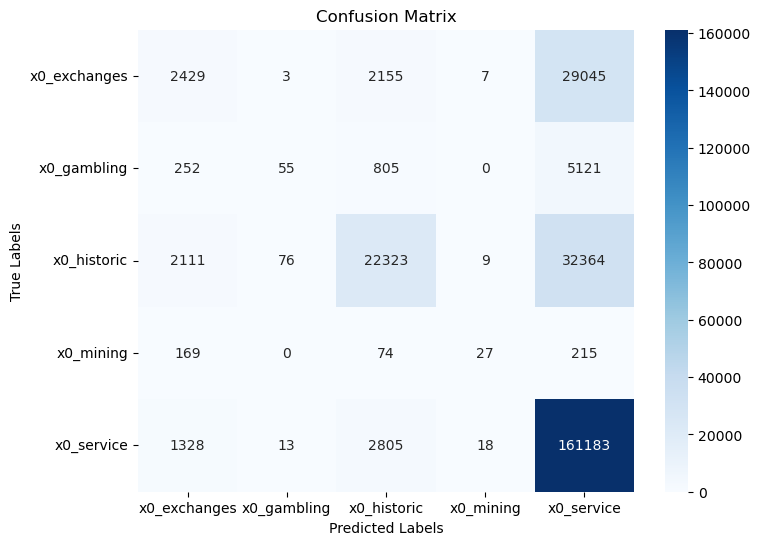

Weighted Accuracy: 70.84%
Weighted Precision: 69.27%
Weighted Recall: 70.54%


,Exchange,Gambling,Historic,Mining,Services
precision,0.515542,0.374150,0.792664,0.442623,0.707166
recall,0.048812,0.008824,0.392437,0.055670,0.974817
f1-score,0.089181,0.017241,0.524969,0.098901,0.819696
support,33639.000000,6233.000000,56883.000000,485.000000,165347.000000


In [12]:
from sklearn.metrics import accuracy_score,precision_score, recall_score

# Assuming df_classify is your DataFrame
#X = df_classify.drop(["type","Balance"], axis=1)
X = df_classify[significant_columns]

y = df_classify["type"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to NumPy array before reshaping
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = onehot_encoder.transform(y_test.reshape(-1, 1))
label_mapping = {i: label for i, label in enumerate(onehot_encoder.get_feature_names_out())}

optimal_k = grid_search.best_params_['n_neighbors']
optimal_metric = grid_search.best_params_['metric']
optimal_weight = grid_search.best_params_['weights']
optimal_algorithm = grid_search.best_params_['algorithm']


knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=optimal_k,metric=optimal_metric,weights=optimal_weight,algorithm=optimal_algorithm)
knn_classifier.fit(X_train, y_train_encoded)
predictions = knn_classifier.predict(X_test)


report = classification_report(y_test_encoded, predictions, output_dict=True, zero_division=1)
report_df = pd.DataFrame(report)
report_df.rename(columns={'0': 'Exchange', '1': 'Gambling','2':'Historic','3':'Mining','4':'Services'}, inplace=True)
report_df.drop(columns=['micro avg','macro avg', 'weighted avg','samples avg'],inplace=True)
overall_accuracy = accuracy_score(y_test_encoded, predictions)
overall_precision = precision_score(y_test_encoded, predictions, average='weighted', zero_division=1)
overall_recall = recall_score(y_test_encoded, predictions, average='weighted', zero_division=1)

conf_matrix = confusion_matrix(y_test_encoded.argmax(axis=1), predictions.argmax(axis=1))
class_labels = list(label_mapping.values())


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

weighted_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
weighted_precision = (report_df.loc['precision'] * report_df.loc['support']).sum() / report_df.loc['support'].sum()
weighted_recall = (report_df.loc['recall'] * report_df.loc['support']).sum() / report_df.loc['support'].sum()

print("Weighted Accuracy: {:.2%}".format(weighted_accuracy))
print("Weighted Precision: {:.2%}".format(weighted_precision))
print("Weighted Recall: {:.2%}".format(weighted_recall))

report_df

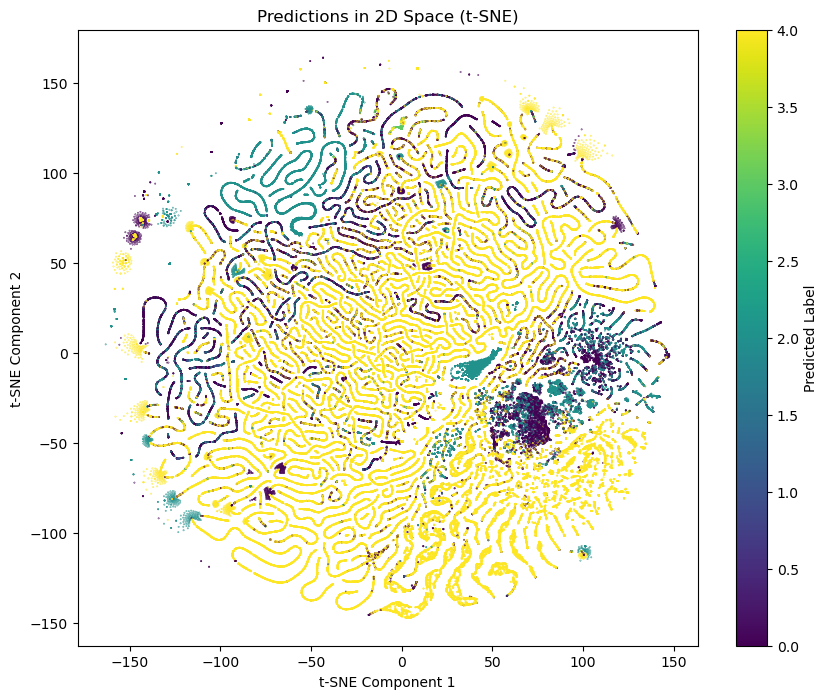

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_test)

pred_df = pd.DataFrame({'TSNE1': X_2d[:, 0], 'TSNE2': X_2d[:, 1], 'True Label': y_test_encoded.argmax(axis=1), 'Predicted Label': predictions.argmax(axis=1)})

# Plot the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_df['TSNE1'], pred_df['TSNE2'], c=pred_df['Predicted Label'], cmap='viridis', s=0.1)
plt.colorbar(scatter, label='Predicted Label')
plt.title('Predictions in 2D Space (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [28]:
significant_columns

['Average_Partners_Per_Day',
 'Avg_Inputs_Transactions_Day',
 'Output_Proportion',
 'Avg_Daily_Transactions',
 'Avg_Outputs_Transactions_Day',
 'Balance',
 'Max_Input_Day']

#### Discussion

We begin by calculating various features:

- From part 2: Balance, Transaction Count, and Average/Max Transaction Output: These statistics provide insight into the financial activity of a Bitcoin wallet, helping discern patterns and behaviors associated with specific categories such as mining, services, gambling, exchanges, or historic wallets.

- Average Amount of Partners per Day: The average number of partners per day reflects the diversity of transactional relationships, with certain categories like exchanges expected to engage with a higher number of partners compared to mining or historic wallets.

- Output Proportion + Counts: Examining the proportion and counts of transaction outputs offers clues about the wallet's purpose, distinguishing characteristics specific to mining, service, gambling, exchanges, or historic wallets based on their unique transaction output patterns.

- Transactions per Day: The frequency of transactions per day is a key metric for differentiating between wallet categories, as certain types, such as exchanges, are likely to exhibit higher transaction volumes compared to mining or historic wallets.

- Max Input, Output, and Transactions per Day: Identifying the maximum values for inputs, outputs, and transactions per day helps capture extreme behaviors within each category, allowing the classifier to account for potential outliers and better characterize wallet types.

- Transactions per Weekday: Analyzing transaction patterns throughout the week provides additional context, as certain categories, like gambling or service wallets, may demonstrate distinctive activity patterns on specific weekdays, aiding in the classification process.

We then run an ANOVA test to deduce what features are statistically significantly related to the output variable and select the following features for our classifier:
- 'Average_Partners_Per_Day',
- 'Avg_Inputs_Transactions_Day',
- 'Output_Proportion',
- 'Avg_Daily_Transactions',
- 'Avg_Outputs_Transactions_Day',
- 'Balance',
- 'Max_Input_Day'

Using our significant columns we ran a gridsearch on a subset of our data to select the optimal parameters for our KNN classifier. The following parameters were then selected to train a model on the full dataset:
- Best k: 7
- Best metric: manhattan
- Best weight: uniform
- Best algorithm: ball_tree
- Best Accuracy: 70.21

The gridsearch achieved a 70.21% accuracy. We then performed a train-test split on the full dataset and trained a KNN model on the train set and used it to make predictions on the test set. The confusion matrix and classification report are output above. Our model performed as follows:
- Weighted Accuracy: 70.84%
- Weighted Precision: 69.27%
- Weighted Recall: 70.54%

However, when deep diving into the individual categories one can see that the classifier's performance varies across categories. For dominant categories such as Services and Historic a strong F1 score was achieved, while for underrepresented categories precision and recall is not particularly good. However, when weighted, the model performance is acceptable.

To improve the model one could think of further features and one should also try and include more data, as computational limitations did not allow for more extensive models. Additionally, assumptions that were made in part 2 for calculating statistics might have harmed our overall performance. 

Finally, we applied t-SNE dimensionality reduction methods to visualise our predictions. It becomes obvious that there are some clusters where that our classifier identified, however, it also becomes apparent that there is still room for improvement, as the lack of clear clusters and partitions will lead to misclassifications. 

## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


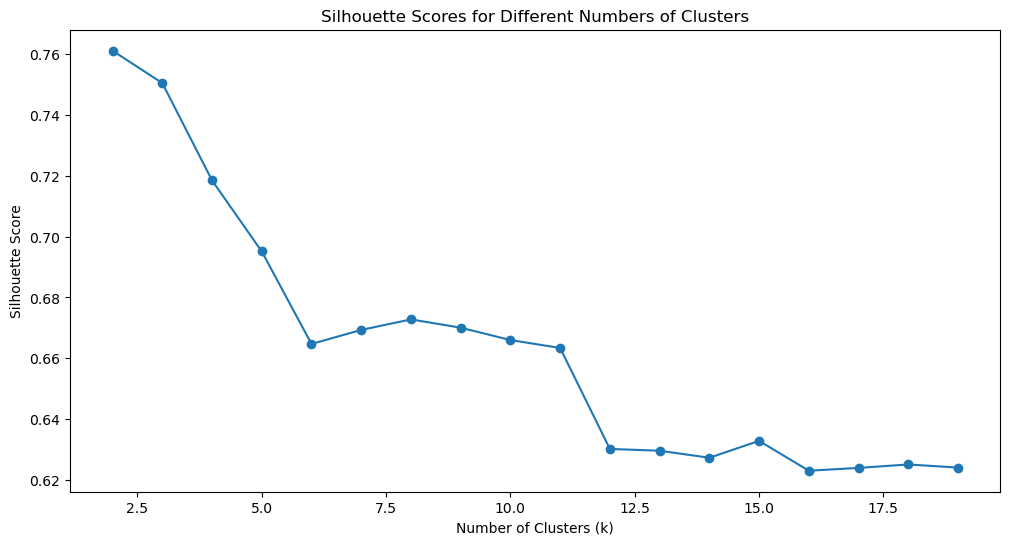

Optimal k: 2


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
cluster_df = df_classify_subset.drop(columns=["type"]+insignificant_columns)
scaler = StandardScaler()
cluster_df_normalized = scaler.fit_transform(cluster_df)

Q1 = cluster_df.quantile(0.25)
Q3 = cluster_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((cluster_df < (Q1 - 1.5 * IQR)) | (cluster_df > (Q3 + 1.5 * IQR))).any(axis=1)


cluster_df_no_outliers = cluster_df[~outliers]
cluster_df_normalized_no_outliers = scaler.transform(cluster_df_no_outliers)

def evaluate(data, k):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    model = kmeans.fit(data)
    labels = model.labels_
    score = silhouette_score(data, labels)
    return score

# Evaluate clustering performance for different values of k
scores = [(k, evaluate(cluster_df_normalized_no_outliers, k)) for k in range(2, 20)]

# Create a DataFrame to store the results
scores_df = pd.DataFrame(scores, columns=['k', 'score'])

# Find the optimal k based on the highest silhouette score
optimal_k = scores_df['k'][scores_df['score'].idxmax()]

# Plot the silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(scores_df['k'], scores_df['score'], marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Print the optimal k
print("Optimal k: {}".format(optimal_k))

In [28]:
from sklearn.manifold import TSNE
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=1)

# Fit KMeans directly to the original dataset
kmeans_labels = kmeans.fit_predict(cluster_df_normalized_no_outliers)

# Apply t-SNE to visualize the clustered data
tsne = TSNE(n_components=2, perplexity=2, random_state=1)
tsne_result = tsne.fit_transform(cluster_df_normalized_no_outliers)

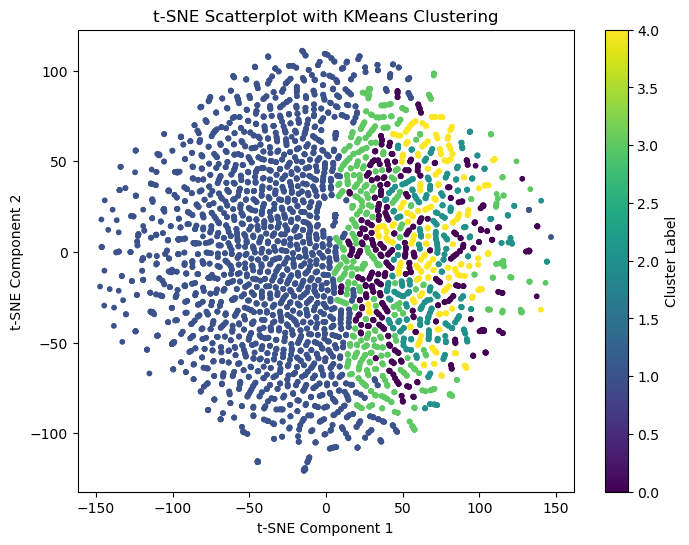

In [29]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Scatterplot with KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


#### Discussion

Our proposed solution utilized clustering to determine potential groupings of Bitcoin addresses, we perform our Analysis on the same subset that the classifier was optimised on. The silhouette scores method was used to determine the optimal number of clusters. With a silhouette score peaking around 0.98 for two clusters, we continued our analysis with k=2, however, we believe if the dataset would be complete and further features were calculated, we could obtain more than just two clusters, representing the various industries present in the Bitcoin landscape.

Proceeding with the optimal cluster of 2, we applied the KMeans algorithm to partition the addresses into two distinct clusters. The KMeans model, informed by the silhouette analysis, allows us to identify and analyze clusters that exhibit similar characteristics or behaviors.

To visualize the clustering results and provide an intuitive understanding of the groupings, we employed a t-SNE plot. The resulting scatterplot aims to highlight the separation and concentration of the clusters.

The resulting t-SNE plot does not look like clusters were formed optimally, this might also be due to the fact that visualising the data on a 2-d space is difficult. Most of the points are assigned to the yellow cluster, there are some small individual clusters that can be identified, but there is also a line of accounts that flow through the graph, this might be due to the fundamentals of bitcoin ledgers, but further analyses would have to be performed to truly understand the resulted output.

The fact that statistics that were used to perform clusters are only on a subset of data of the entire bitcoin ledger limits the power of the result.


## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

We propose a community detection algorithm using cuDF and cuGraphs. Specifically we will use the Louvain Algorithm to detect communities within the Bitcoin ledger, we will then plot the top 10 communities by size to visualise the network.

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

if IN_COLAB:
    !apt-get install openjdk-11-jdk-headless
    !pip install pyspark
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.2-s_2.12.jar pyspark-shell'



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.21+9-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=179b964ca296044f71cbab741498f5fef65f90377caf1f4958cf289a7a9aa402
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
--2023-12-02 23:17:13--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 18.239.94.54, 18.239.94.102, 18.239.94.48, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|18.239.94.54|:443...

In [2]:
!nvidia-smi
!nvcc -V

Sat Dec  2 23:17:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x

!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
Found existing installation: tensorboard 2.14.1
Uninstalling tensorboard-2.14.1:
  Successfully uninstalled tensorboard-2.14.1
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 9.5 MB/s eta 0:00:00
  

In [4]:
import cudf


inputDF = cudf.read_csv("inputDF.csv")
outputDF = cudf.read_csv("outputDF.csv")


inputDF_renamed = inputDF[['TxId', 'Time', 'Input']]
outputDF_renamed = outputDF[['TxId', 'Time', 'Output', 'Value']]


merged_df = inputDF_renamed.merge(outputDF_renamed, on=['TxId'], how='left').drop(columns=["Time_x", "Time_y"]).dropna()

merged_df = merged_df[merged_df['Input'] != merged_df['Output']]

In [5]:
random_subset = merged_df.sample(n=100000, random_state=42)

<ipython-input-9-e78eee070ec7>:71: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G_subset_filtered_nx.nodes, num_nodes_to_select)
<ipython-input-9-e78eee070ec7>:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G_subset_filtered_nx, pos, node_color=node_colors_filtered, cmap=plt.cm.get_cmap('viridis', 11), node_size=node_sizes, alpha=0.7)


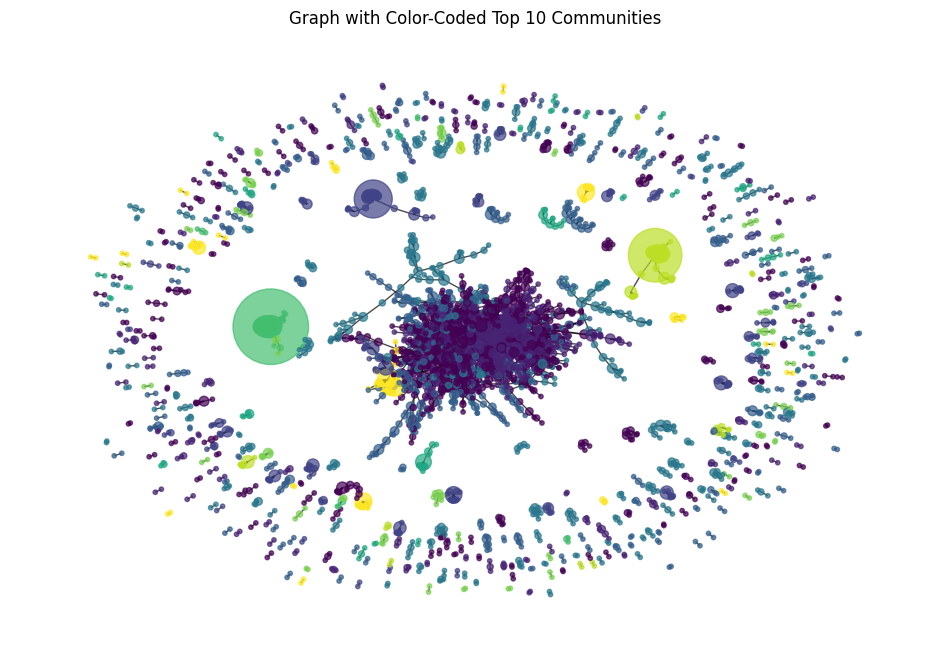

In [9]:
import cudf
import cugraph
import networkx as nx
import matplotlib.pyplot as plt
import random


edges_cudf = random_subset[['Input', 'Output', 'Value']].rename(columns={'Input': 'src', 'Output': 'dst'})
edges_cudf['Value'] = edges_cudf['Value'].astype('float64')  # Ensure 'Value' is in a suitable format


g = cugraph.Graph()
g.from_cudf_edgelist(edges_cudf, source='src', destination='dst', edge_attr='Value')


df_louvain, modularity_score = cugraph.louvain(g)


df_louvain = df_louvain[['vertex', 'partition']]


partition_counts = df_louvain.groupby('partition').count().reset_index()
partition_counts = partition_counts.sort_values(by='vertex', ascending=False).head(10)



resultData_cudf = df_louvain.merge(partition_counts[['partition']], on='partition', how='right')

counts_result_cudf = resultData_cudf.groupby('partition').count().reset_index()
counts_result_cudf = counts_result_cudf.rename(columns={'partition': 'partition_count'})


edges_cudf = random_subset[['Input', 'Output', 'Value']].rename(columns={'Input': 'src', 'Output': 'dst'})
edges_cudf['Value'] = edges_cudf['Value'].astype('float64')  # Ensure 'Value' is in a suitable format


G_cugraph = cugraph.Graph()
G_cugraph.from_cudf_edgelist(edges_cudf, source='src', destination='dst', edge_attr='Value')


df_louvain, modularity_score = cugraph.louvain(G_cugraph)


result_pd = df_louvain.to_pandas()

G_nx = nx.from_pandas_edgelist(edges_cudf.to_pandas(), 'src', 'dst', ['Value'])


top_communities = result_pd['partition'].value_counts().head(10).index.tolist()

subset_nodes = result_pd[result_pd['partition'].isin(top_communities)]['vertex'].tolist()

G_subset_nx = G_nx.subgraph(subset_nodes)

community_colors = dict(zip(top_communities, range(10)))


node_colors_all = [community_colors.get(partition, 10) for partition in result_pd[result_pd['vertex'].isin(subset_nodes)]['partition']]

G_subset_filtered_nx = G_subset_nx.subgraph([node for node in G_subset_nx.nodes() if G_subset_nx.degree(node) > 0])

num_nodes_to_select = int(0.4 * len(G_subset_filtered_nx.nodes))

random_nodes = random.sample(G_subset_filtered_nx.nodes, num_nodes_to_select)

G_subset_filtered_nx = G_subset_filtered_nx.subgraph(random_nodes)

G_subset_filtered_nx = G_subset_filtered_nx.subgraph([node for node in G_subset_filtered_nx.nodes() if G_subset_filtered_nx.degree(node) > 0])

node_colors_filtered = [node_colors_all[subset_nodes.index(node)] for node in G_subset_filtered_nx.nodes()]

node_degrees = G_subset_filtered_nx.degree()

node_sizes = [10 * node_degrees[node] for node in G_subset_filtered_nx.nodes()]

fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G_subset_filtered_nx)
nx.draw(G_subset_filtered_nx, pos, node_color=node_colors_filtered, cmap=plt.cm.get_cmap('viridis', 11), node_size=node_sizes, alpha=0.7)

plt.title('Graph with Color-Coded Top 10 Communities')
plt.show()


#### Discussion

We used cudf and cugraphs to conduct a community detection algorithm. We then picked the 10 largest communities, selected nodes with at least 1 edge and plotted a subset of those nodes and edges using networkx and matplotlib libraries. We decided to only display a subset of the data, as the full dataset would result in overplotting and the subset is still representative of the overall network structure. 

Analysing the plot, we can see that there are several communities some of which are interconnected, others that are isolated. Here it is important to consider that we are only looking at a subset. We also decided to only plot nodes with atleast one edge. Size of nodes represent the amount of edges, bigger nodes are more important players within a community. These could represent exchanges etc.

The output dataframes and graphs of the algorithm can be used to identify communities within the ledger as well as major players. This can help in various cases such as fraud detection by looking at anomalies within communities, understand transaction flows as well as security and risk assessments.

The fact that only a subset was plotted resulted in some isoalted nodes and edges that belong to a community which they are not connected to on the graph.

In a further analysis, one could, first of all plot and visualise the entire dataset or bitcoin ledger and then depict industry labels, to even better understand the formed communities.